## 0 Imports and Constants

In [13]:
## 0 Imports and Constants
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import seaborn as sns
from torch.utils.data import DataLoader
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_clas, train_test_split, accuracy
from data_evaluation.visual.visual_evaluation import visualize
from data_evaluation.predictive.predictive_evaluation import predictive_evaluation
from data_evaluation.discriminative.discriminative_model import LSTMClassification, CNNClassification, train_cnn
from predictive.LSTM import train_model
from predictive.TimeSeriesDataset import TimeSeriesDataset

DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"

In [14]:
MODEL = "lstm"

if MODEL == "lstm":
    hyperparameters = {
        "lr": 0.0001,
        "batch_size": 32,
        "hidden_size": 8,
        "num_layers": 1,
        "bidirectional": True,
        "output_logits": True,
        "num_epochs": 10000,
        "device": 'cuda' if torch.cuda.is_available() else 'cpu'
    }

elif MODEL == "cnn":
    hyperparameters = {
        "lr": 0.00001,
        "batch_size": 32,
        "num_epochs": 1000,
        "device": 'cuda' if torch.cuda.is_available() else 'cpu'
    }

## 1 Loading Data

In [15]:
data = load_sequential_time_series(SYNTHETIC_DATA_FOLDER / 'discriminative_train' / 'discriminative_train_42000_13_5.csv', shape=(42000, 13, 5))

In [16]:
train, test = train_test_split(data, split_ratio=0.8)
test, val = train_test_split(test, split_ratio=0.5)

In [17]:
X_batch_train, y_batch_train, X_test, y_test, X_batch_val, y_batch_val = extract_features_and_targets_clas(train, test, val)

In [18]:
scaler = Scaler(X_batch_train)

In [19]:
X_batch_train = scaler.scale_data(X_batch_train)
X_test = scaler.scale_data(X_test)
X_batch_val = scaler.scale_data(X_batch_val)

In [20]:
# put data on tensors (since they had to be numpy arrays for the scaler)
X_batch_train = torch.tensor(X_batch_train, dtype=torch.float32)
y_batch_train = torch.tensor(y_batch_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_batch_val = torch.tensor(X_batch_val, dtype=torch.float32)
y_batch_val = torch.tensor(y_batch_val, dtype=torch.float32)

In [21]:
train_dataset = TimeSeriesDataset(X_batch_train, y_batch_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
val_dataset = TimeSeriesDataset(X_batch_val, y_batch_val)

train_loader = DataLoader(train_dataset, batch_size=hyperparameters["batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters["batch_size"], shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=hyperparameters["batch_size"], shuffle=False)

## 2 Training the model

In [22]:
criterion = nn.BCEWithLogitsLoss()

In [23]:
val_losses = []
val_accs = []
train_losses = []
train_accs = []

In [24]:
if MODEL == 'lstm':

    model = LSTMClassification(
        device=hyperparameters["device"],
        batch_size=hyperparameters["batch_size"],
        input_size=X_batch_train.shape[2],
        hidden_size=hyperparameters["hidden_size"],
        num_stacked_layers=hyperparameters["num_layers"],
        bidirectional=hyperparameters["bidirectional"],
        output_logits=hyperparameters["output_logits"]
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters["lr"])

    train_losses, train_accs, val_losses, val_accs, model = train_model(
                        model=model,
                        train_loader=train_loader,
                        val_loader=val_loader,
                        criterion=criterion,
                        optimizer=optimizer,
                        device=hyperparameters["device"],
                        num_epochs=hyperparameters["num_epochs"],
                        verbose=True)
    
elif MODEL == 'cnn':

    ### Model ### 
    model = CNNClassification(verbose=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters['lr'])

    train_losses, val_losses, train_accs, val_accs, model = train_cnn(
        model=model,
        hyperparameters=hyperparameters,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
    )

Epoch: 1
Training Loss: 0.6968076458573341
Training Loss: 0.6930876269936561
Training Loss: 0.6932913509011268
Training Loss: 0.6934559124708176
Training Loss: 0.6932957518100739
Validation Loss: 0.6933555020527407
Validation Accuracy: 49.52651515151515
**************************************************
Epoch: 2
Training Loss: 0.6966427996754646
Training Loss: 0.6931018134951592
Training Loss: 0.6932170552015304
Training Loss: 0.6932997006177902
Training Loss: 0.6932790893316269
Validation Loss: 0.6932665926940513
Validation Accuracy: 49.43181818181818
**************************************************
Epoch: 3
Training Loss: 0.6965732488036156
Training Loss: 0.6930795410275459
Training Loss: 0.6931541180610656
Training Loss: 0.6932127088308334
Training Loss: 0.6932390806078911
Validation Loss: 0.6931674019856886
Validation Accuracy: 50.18939393939394
**************************************************
Epoch: 4
Training Loss: 0.6965156415104866
Training Loss: 0.6930508828163147
Training

## 3 Evaluate Training

Text(0.5, 1.0, 'Validation Accuracy')

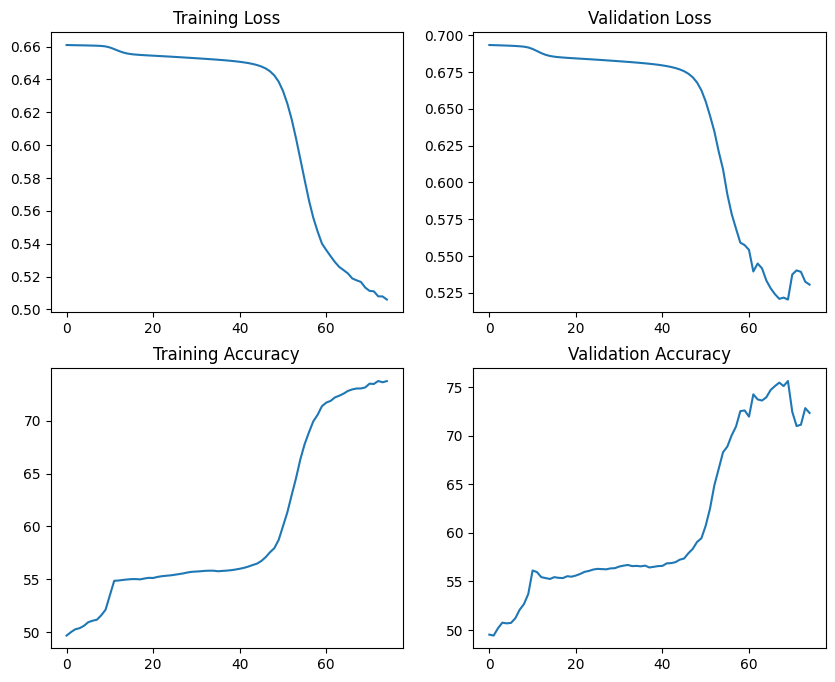

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    # Diagramm 1 (oben links)
axs[0, 0].plot(train_losses, label="BCELoss")
axs[0, 0].set_title('Training Loss')

axs[0, 1].plot(val_losses, label="BCELoss")
axs[0, 1].set_title('Validation Loss')

axs[1, 0].plot(train_accs, label="Accuracy")
axs[1, 0].set_title('Training Accuracy')

axs[1, 1].plot(val_accs, label="Accuracy")
axs[1, 1].set_title('Validation Accuracy')

In [26]:
autoencoder_test = load_sequential_time_series(SYNTHETIC_DATA_FOLDER / 'discriminative_test' / 'discriminative_test_autoencoder_3000_13_5.csv', shape=(3000, 13, 5))
jitt_01_test = load_sequential_time_series(SYNTHETIC_DATA_FOLDER / 'discriminative_test' / 'discriminative_test_jitt_01_3000_13_5.csv', shape=(3000, 13, 5))
jitt_02_test = load_sequential_time_series(SYNTHETIC_DATA_FOLDER / 'discriminative_test' / 'discriminative_test_jitt_02_3000_13_5.csv', shape=(3000, 13, 5))
jitt_005_test = load_sequential_time_series(SYNTHETIC_DATA_FOLDER / 'discriminative_test' / 'discriminative_test_jitt_005_3000_13_5.csv', shape=(3000, 13, 5))
timegan_gru_test = load_sequential_time_series(SYNTHETIC_DATA_FOLDER / 'discriminative_test' / 'discriminative_test_timegan_gru_3000_13_5.csv', shape=(3000, 13, 5))
timegan_lstm_test = load_sequential_time_series(SYNTHETIC_DATA_FOLDER / 'discriminative_test' / 'discriminative_test_timegan_lstm_3000_13_5.csv', shape=(3000, 13, 5))
timewarp_test = load_sequential_time_series(SYNTHETIC_DATA_FOLDER / 'discriminative_test' / 'discriminative_test_timewarp_3000_13_5.csv', shape=(3000, 13, 5))

FileNotFoundError: ../../data/synthetic/discriminative_test/discriminative_test_autoencoder_3000_13_5.csv not found.

In [ ]:
results = pd.DataFrame(columns=['Method', 'Accuracy'])

In [ ]:
def get_discriminative_test_performance(model, test_data, method, results):

    X_test, y_test = extract_features_and_targets_clas(test_data)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    with torch.inference_mode(): 
        test_logits = model(X_test.to(hyperparameters['device'])) # get plain model output (logits)
        test_probs = torch.sigmoid(test_logits) # get probabilities
        test_preds = torch.round(test_probs) # get classes

        test_acc = accuracy(y_true=y_test, y_pred=torch.tensor(test_preds))
        print(test_acc)
        
        results = pd.concat([results, pd.DataFrame([{'Method': method, 'Accuracy': test_acc}])], ignore_index=True)

    return results

In [ ]:
results = get_discriminative_test_performance(model, autoencoder_test, 'Autoencoder', results)
results = get_discriminative_test_performance(model, jitt_01_test, 'Jitter 0.1', results)
results = get_discriminative_test_performance(model, jitt_02_test, 'Jitter 0.2', results)
results = get_discriminative_test_performance(model, jitt_005_test, 'Jitter 0.05', results)
results = get_discriminative_test_performance(model, timegan_gru_test, 'TimeGAN GRU', results)
results = get_discriminative_test_performance(model, timegan_lstm_test, 'TimeGAN LSTM', results)
results = get_discriminative_test_performance(model, timewarp_test, 'Timewarp', results)

Extracted features and target from training data.
Shape of X_train: (3000, 12, 5)
Shape of y_train: (3000, 1)
0.0
Extracted features and target from training data.
Shape of X_train: (3000, 12, 5)
Shape of y_train: (3000, 1)
0.0
Extracted features and target from training data.
Shape of X_train: (3000, 12, 5)
Shape of y_train: (3000, 1)
0.06666666666666667
Extracted features and target from training data.
Shape of X_train: (3000, 12, 5)
Shape of y_train: (3000, 1)
0.0
Extracted features and target from training data.
Shape of X_train: (3000, 12, 5)
Shape of y_train: (3000, 1)
0.03333333333333333
Extracted features and target from training data.
Shape of X_train: (3000, 12, 5)
Shape of y_train: (3000, 1)
0.03333333333333333
Extracted features and target from training data.
Shape of X_train: (3000, 12, 5)
Shape of y_train: (3000, 1)
0.03333333333333333


/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_84241/276383998.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_acc = accuracy(y_true=y_test, y_pred=torch.tensor(test_preds))
/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_84241/276383998.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Method': method, 'Accuracy': test_acc}])], ignore_index=True)


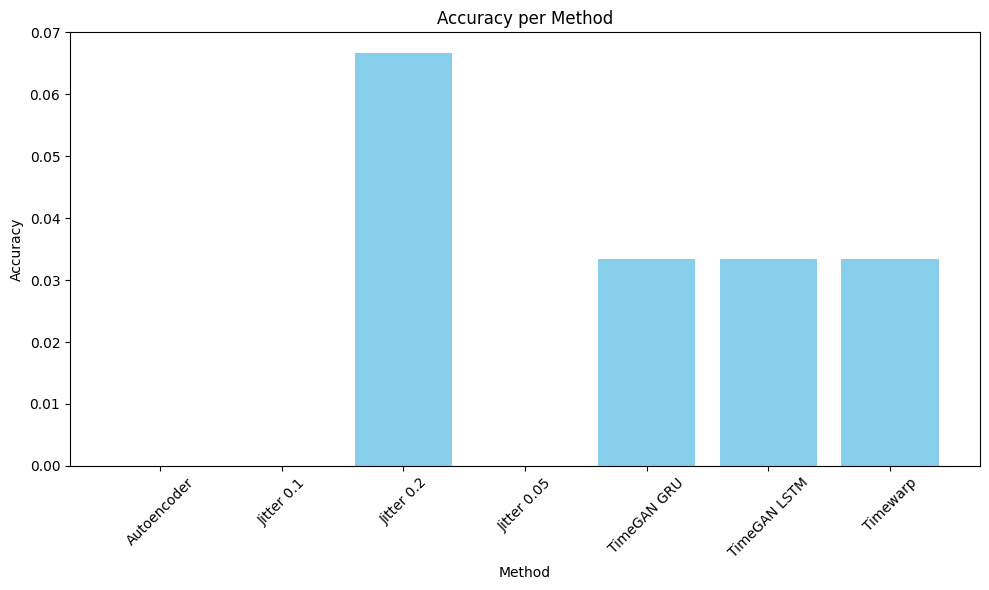

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(results['Method'], results['Accuracy'], color='skyblue')

# Diagramm anpassen
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.title('Accuracy per Method')
plt.xticks(rotation=45)  # Optional: Dreht die Beschriftungen der x-Achse um 45 Grad
plt.tight_layout()

# Diagramm anzeigen
plt.show()

In [ ]:
results.to_csv(f'{MODEL}_results.csv', index=False)

In [ ]:
torch.save(model.state_dict(), f'{MODEL}_model.pth')